# Experiment Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import plotly.express as px

from htc.evaluation.analyze_tfevents import read_tfevent_losses
from htc.models.data.DataSpecification import DataSpecification
from htc.settings import settings
from htc.utils.Config import Config
from htc.utils.helper_functions import utilization_table
from htc.utils.LabelMapping import LabelMapping
from htc.utils.visualization import (
    create_running_metric_plot,
    create_training_stats_figure,
    show_loss_chart,
    visualize_dict,
)
from htc_projects.context.models.context_evaluation import context_evaluation_table

In [2]:
# Parameter for papermill
run_dir = settings.training_dir / "image/2023-02-08_14-48-02_organ_transplantation_0.8"

In [3]:
assert run_dir != "", "No run_dir specified"
if type(run_dir) == str:
    run_dir = Path(run_dir)
print(f"Model: {run_dir.parent.name}")
print(f"Experiment: {run_dir.name}")

Model: image
Experiment: 2023-02-08_14-48-02_organ_transplantation_0.8


In [4]:
# Load training files
df_train = read_tfevent_losses(run_dir)
config = Config(run_dir / "config.json")
specs = DataSpecification(run_dir / "data.json")
mapping = LabelMapping.from_config(config)

## Config

In [5]:
visualize_dict(config.data)

## Metrics
Visualization of the metrics stored in the TensorBoard events file (everything which is logged via `selg.log()`).

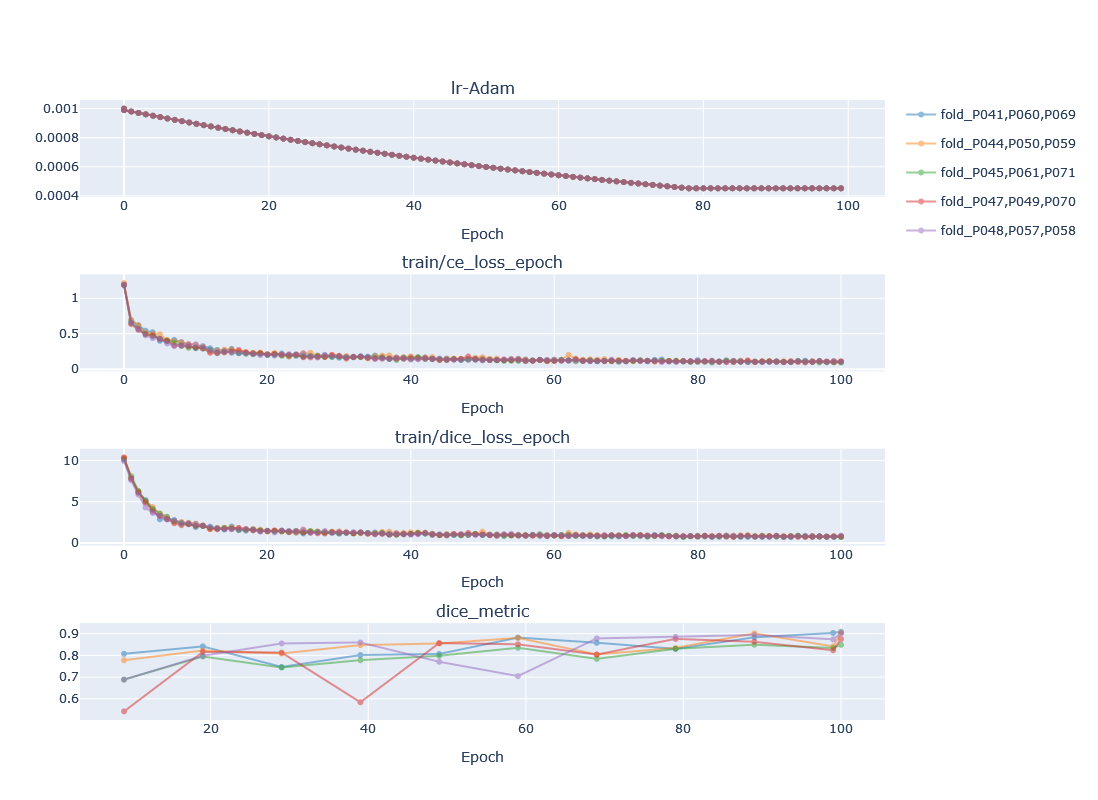

In [6]:
show_loss_chart(df_train)

For each fold, the current maximum for every epoch of the main metric (the checkpoint metric, `validation/checkpoint_metric` in the config).

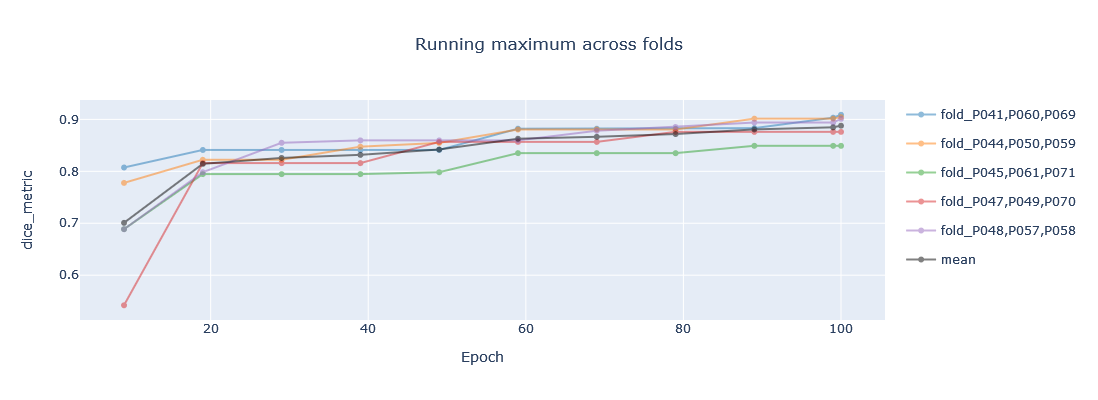

In [7]:
create_running_metric_plot(df_train)

## Training Statistics
The following heatmaps visualize which images the network saw during training. On the $y$-axis is the sorted (by image name) list of images and on the $x$-axis we have the training epochs. For each fold and epoch, we can see how often the network saw a particular image. Usually, we want a random order of images, so if you have the feeling you are looking at a noise image, everything is fine :-)

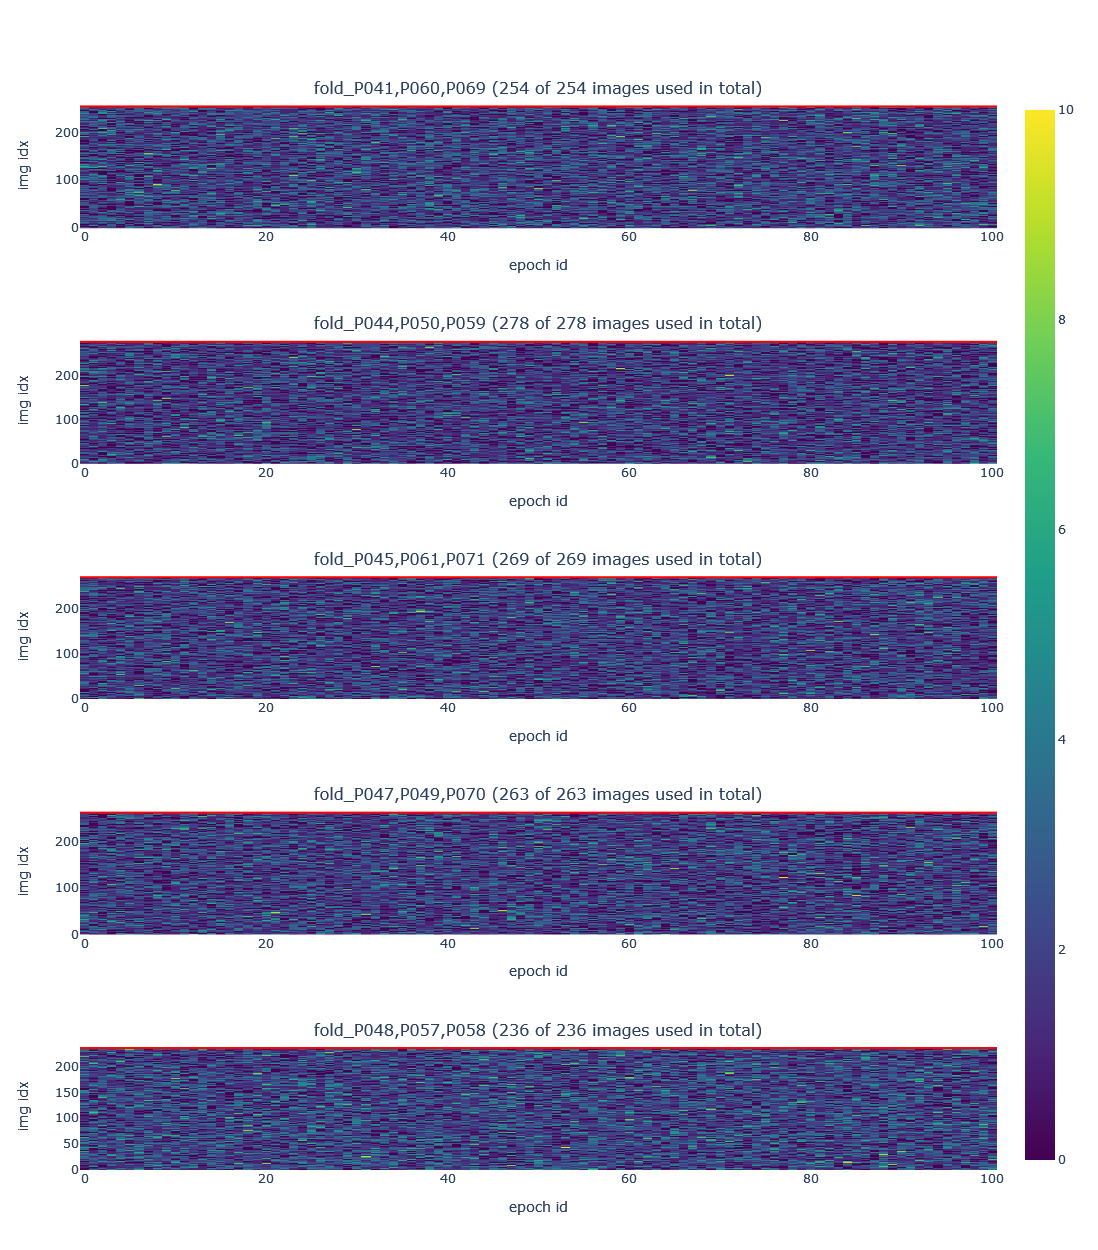

In [8]:
if len(sorted(run_dir.rglob("trainings_stats.npz"))) > 0:
    fig = create_training_stats_figure(run_dir)
    fig.show()

## Hardware Utilization
GPU and CPU utilization for each fold.
> Note: You will only get reasonable numbers if the training was long enough. For super short training times, you might get warnings or nan values

In [9]:
utilization_table(run_dir)

,fold,node,hours,gpu_util_mean,gpu_util_std,cpu_util_mean,cpu_util_std
0,"fold_P041,P060,P069",hdf18-gpu06,1.397594,0.815904,0.101339,0.202108,0.018776
1,"fold_P044,P050,P059",hdf18-gpu06,1.397628,0.812188,0.103697,0.201675,0.016855
2,"fold_P045,P061,P071",hdf18-gpu18,1.397779,0.823097,0.101162,0.202896,0.020155
3,"fold_P047,P049,P070",hdf18-gpu18,1.397810,0.820160,0.107158,0.202863,0.020438
4,"fold_P048,P057,P058",hdf18-gpu15,1.398156,0.787882,0.125850,0.201930,0.020085


## Validation performance
Note: the real datasets (from masks_isolation onwards) are always computed using the test predictor, i.e. with ensembling.

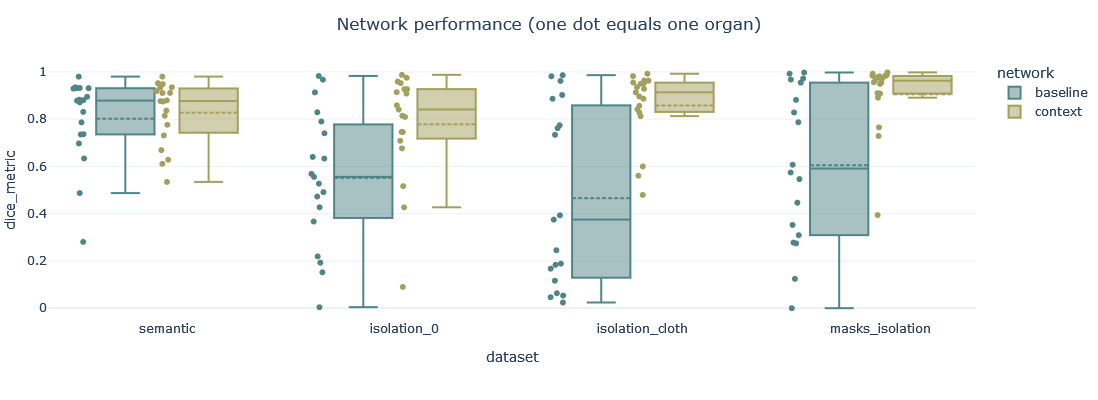

In [10]:
df_val_agg = context_evaluation_table(run_dir)
network_colors = {"baseline": "#508587", "context": "#A39F5D"}

fig = px.box(
    df_val_agg,
    x="dataset",
    color="network",
    y="dice_metric",
    hover_name="label_name",
    points="all",
    color_discrete_map=network_colors,
)
fig.update_traces(boxmean=True)
fig.update_layout(yaxis_range=[-0.05, 1.05], xaxis_range=[-0.5, df_val_agg["dataset"].nunique() - 0.6])
fig.update_layout(template="plotly_white", height=400, width=1000, margin=dict(l=0))
fig.update_layout(title_x=0.5, title_text="Network performance (one dot equals one organ)")